In [1]:
import re
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import scipy.cluster.hierarchy as sch
from sklearn. preprocessing import StandardScaler
from sklearn.cluster import KMeans 

from kneed import KneeLocator
 

In [2]:
df=pd.read_csv("bank_transactions.csv")

In [3]:
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [4]:
df.shape

(1048567, 9)

## Data Cleaning

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [6]:
pd.DataFrame({
    'dtype': df.dtypes,
    'nunique': df.nunique(),
    'nulls': df.isnull().sum()
})


,dtype,nunique,nulls
TransactionID,object,1048567,0
CustomerID,object,884265,0
CustomerDOB,object,17254,3397
CustGender,object,3,1100
CustLocation,object,9355,151
CustAccountBalance,float64,161328,2369
TransactionDate,object,55,0
TransactionTime,int64,81918,0
TransactionAmount (INR),float64,93024,0


In [7]:
# delete missing data
df.dropna(inplace=True)

In [8]:
#check for duplication
df.duplicated().sum()

np.int64(0)

In [9]:
# convert type of columns TransactionDate,CustomerDOB from string to datetime
df['TransactionDate']=pd.to_datetime(df['TransactionDate'])
df['CustomerDOB']=pd.to_datetime(df['CustomerDOB'])

C:\Users\91827\AppData\Local\Temp\ipykernel_23252\570098125.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['TransactionDate']=pd.to_datetime(df['TransactionDate'])
C:\Users\91827\AppData\Local\Temp\ipykernel_23252\570098125.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['CustomerDOB']=pd.to_datetime(df['CustomerDOB'])


In [10]:
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,143207,25.0
1,T2,C2142763,2057-04-04,M,JHAJJAR,2270.69,2016-02-08,141858,27999.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,142712,459.0
3,T4,C5342380,2073-09-14,F,MUMBAI,866503.21,2016-02-08,142714,2060.0
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,181156,1762.5


### calculate customer age :

#### CustomerDOB is the birth date of the customer , TransactionDate : is the date of transaction that customer is done

In [11]:
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], format='%d/%m/%Y', errors='coerce')
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%d/%m/%Y', errors='coerce')


In [12]:
df['TransactionDate'].dt.year

0          2016
1          2016
2          2016
3          2016
4          2016
           ... 
1048562    2016
1048563    2016
1048564    2016
1048565    2016
1048566    2016
Name: TransactionDate, Length: 1041614, dtype: int32

In [13]:
## customer's age at the time of transaction

df['CustomerAge'] =df['TransactionDate'].dt.year - df['CustomerDOB'].dt.year

df['CustomerAge']

0          22
1         -41
2          20
3         -57
4          28
           ..
1048562    26
1048563    24
1048564    27
1048565    38
1048566    32
Name: CustomerAge, Length: 1041614, dtype: int32

In [14]:
df.drop(columns=['TransactionTime'],inplace=True)

In [15]:
df.CustGender.value_counts()

CustGender
M    760978
F    280635
T         1
Name: count, dtype: int64

In [16]:
df.drop(df[df['CustGender']=='T'].index,inplace=True)

In [17]:
# for finding out numerical and categorical column

# Select only numeric columns (e.g., int, float) from the DataFrame
num_col = df.select_dtypes(include=np.number)

# Select only non-numeric columns (e.g., object, string, datetime, bool) from the DataFrame
cat_col = df.select_dtypes(exclude=np.number)


print(num_col)
print(cat_col)

         CustAccountBalance  TransactionAmount (INR)  CustomerAge
0                  17819.05                     25.0           22
1                   2270.69                  27999.0          -41
2                  17874.44                    459.0           20
3                 866503.21                   2060.0          -57
4                   6714.43                   1762.5           28
...                     ...                      ...          ...
1048562             7635.19                    799.0           26
1048563            27311.42                    460.0           24
1048564           221757.06                    770.0           27
1048565            10117.87                   1000.0           38
1048566            75734.42                   1166.0           32

[1041613 rows x 3 columns]
        TransactionID CustomerID CustomerDOB CustGender   CustLocation  \
0                  T1   C5841053  1994-10-01          F     JAMSHEDPUR   
1                  T2   C2142763

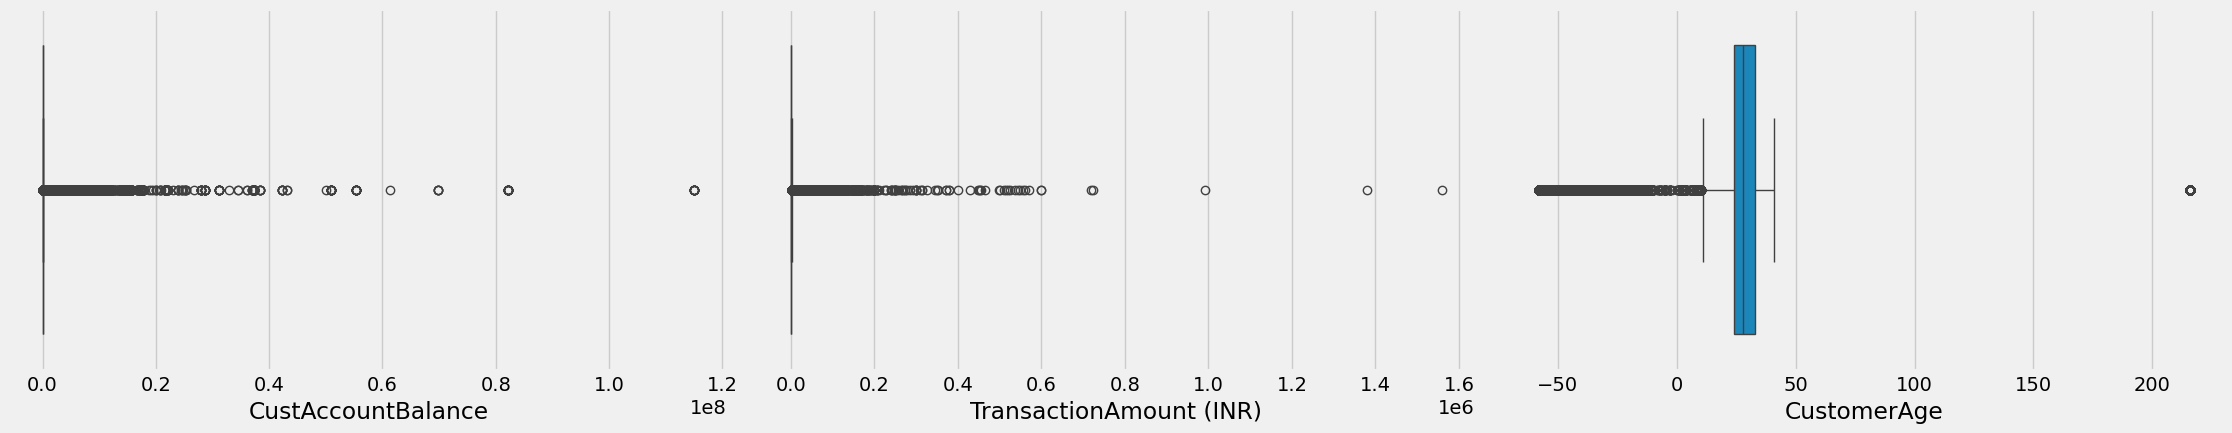

In [18]:
# Use the 'fivethirtyeight' style for better aesthetics (clean and modern look)
plt.style.use("fivethirtyeight")

# Create a new figure with a large size to fit all subplots
plt.figure(figsize=(30, 30))

# Loop through each numeric column to create a boxplot
for index, column in enumerate(num_col):
    
    # Create a subplot in a 7x4 grid (total of 28 possible plots)
    # Place this plot at position (index + 1)
    plt.subplot(7, 4, index + 1)
    
    # Create a boxplot for the current column to visualize distribution and outliers
    sns.boxplot(data=num_col, x=column)

# Adjust layout to prevent overlap between subplots and add padding
plt.tight_layout(pad=1.0)


🔹 No significant outliers were found in the numerical features.
Although some values may appear extreme, they are valid within the business context, so no data was removed.

🔹 A portion of customers shows negative age values, which may seem unusual.
However, this can occur legitimately when Life Saver Youth Savings accounts are opened on behalf of minors not yet born or newly born.

🔹 While the current age calculation uses year-based subtraction, a more precise age logic could be implemented if required.
Data parsing and formatting were verified, and no invalid dates were found.

## RFM analysis

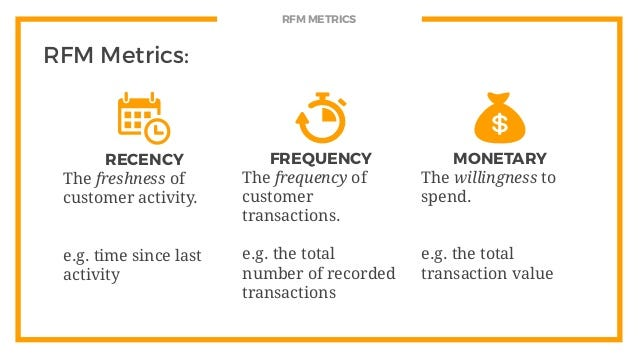

## those two articles will help you to understand this topic 📜:

#### What Are RFM Scores and How To Calculate Them 
(https://www.datacamp.com/tutorial/introduction-customer-segmentation-python)
#### Introduction to Customer Segmentation in Python
(https://connectif.ai/en/blog/what-are-rfm-scores-and-how-to-calculate-them/)

In [19]:
#df['TransactionDate1'] ==> I will keep it to do visaulization
df['TransactionDate1']=df['TransactionDate'] # ==> to calculate the minimum (first transaction)
df['TransactionDate2']=df['TransactionDate'] # ==> to calculate the maximum (last transaction)

In [20]:
MRF_df = df.groupby("CustomerID").agg({
    "TransactionID" : "count",                   # Total number of transactions
    "CustGender" : "first",                      # Gender (assumed constant per customer)
    "CustLocation" : "first",                    # Location (assumed constant per customer)
    "CustAccountBalance" : "mean",               # Avg account balance over all their transactions
    "TransactionAmount (INR)" : "mean",          # Avg transaction amount
    "CustomerAge" : "median",                    # Median age of customer (age may vary if DOB used dynamically)
    "TransactionDate2" : "max",                  # Most recent transaction (Recency base)
    "TransactionDate1" : "min",                  # First transaction (Tenure base)
    "TransactionDate" : "median"                 # Median purchase date (buying habit insight)
})
MRF_df = MRF_df.reset_index()
MRF_df.head()


,CustomerID,TransactionID,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDate2,TransactionDate1,TransactionDate
0,C1010011,2,F,NOIDA,76340.635,2553.0,28.5,2016-09-26,2016-09-08,2016-09-17
1,C1010012,1,M,MUMBAI,24204.490,1499.0,22.0,2016-08-14,2016-08-14,2016-08-14
2,C1010014,2,F,MUMBAI,100112.950,727.5,28.0,2016-07-08,2016-01-08,2016-04-08
3,C1010018,1,F,CHAMPARAN,496.180,30.0,26.0,2016-09-15,2016-09-15,2016-09-15
4,C1010024,1,M,KOLKATA,87058.650,5000.0,-49.0,2016-08-18,2016-08-18,2016-08-18


In [21]:
MRF_df.shape

(879357, 10)

In [22]:
MRF_df.drop(columns=["CustomerID"],inplace=True)

In [23]:
MRF_df.rename(columns={"TransactionID":"Frequency"},inplace=True)

In [24]:
MRF_df.head()

,Frequency,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDate2,TransactionDate1,TransactionDate
0,2,F,NOIDA,76340.635,2553.0,28.5,2016-09-26,2016-09-08,2016-09-17
1,1,M,MUMBAI,24204.490,1499.0,22.0,2016-08-14,2016-08-14,2016-08-14
2,2,F,MUMBAI,100112.950,727.5,28.0,2016-07-08,2016-01-08,2016-04-08
3,1,F,CHAMPARAN,496.180,30.0,26.0,2016-09-15,2016-09-15,2016-09-15
4,1,M,KOLKATA,87058.650,5000.0,-49.0,2016-08-18,2016-08-18,2016-08-18


In [25]:
MRF_df['Recency']=MRF_df['TransactionDate2']-MRF_df['TransactionDate1']

In [26]:
MRF_df.head()

,Frequency,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDate2,TransactionDate1,TransactionDate,Recency
0,2,F,NOIDA,76340.635,2553.0,28.5,2016-09-26,2016-09-08,2016-09-17,18 days
1,1,M,MUMBAI,24204.490,1499.0,22.0,2016-08-14,2016-08-14,2016-08-14,0 days
2,2,F,MUMBAI,100112.950,727.5,28.0,2016-07-08,2016-01-08,2016-04-08,182 days
3,1,F,CHAMPARAN,496.180,30.0,26.0,2016-09-15,2016-09-15,2016-09-15,0 days
4,1,M,KOLKATA,87058.650,5000.0,-49.0,2016-08-18,2016-08-18,2016-08-18,0 days


In [27]:
MRF_df['Recency']=MRF_df['Recency'].astype(str)

In [28]:
# extract the day
x='18 day'
re.search('\d+',x).group()

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\91827\AppData\Local\Temp\ipykernel_23252\2063254094.py:3: SyntaxWarning: invalid escape sequence '\d'
  re.search('\d+',x).group()


'18'

In [29]:
MRF_df['Recency']=MRF_df['Recency'].apply(lambda x :re.search('\d+',x).group())
MRF_df['Recency']=MRF_df['Recency'].astype(int)

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\91827\AppData\Local\Temp\ipykernel_23252\3841689695.py:1: SyntaxWarning: invalid escape sequence '\d'
  MRF_df['Recency']=MRF_df['Recency'].apply(lambda x :re.search('\d+',x).group())


### 0 days mean that a customer has done transaction recently one time by logic so I will convert 0 to 1

In [30]:
def rep_0(i):
    if i==0:
        return 1
    else:
        return i
MRF_df['Recency']=MRF_df['Recency'].apply(rep_0)

In [31]:
MRF_df.drop(columns=["TransactionDate1","TransactionDate2"],inplace=True)

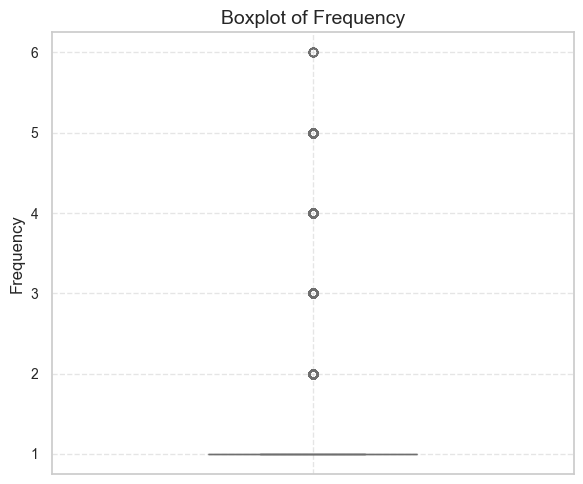

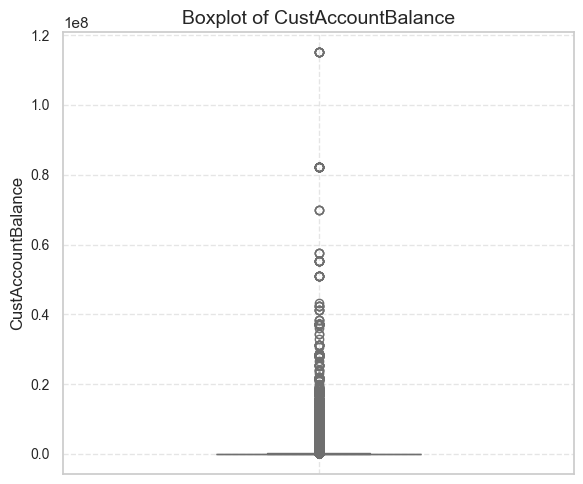

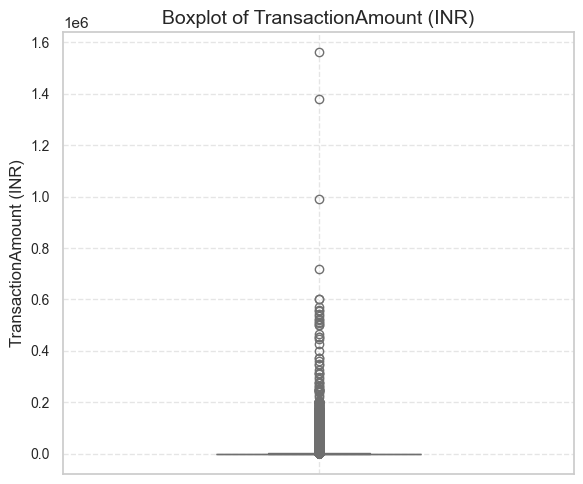

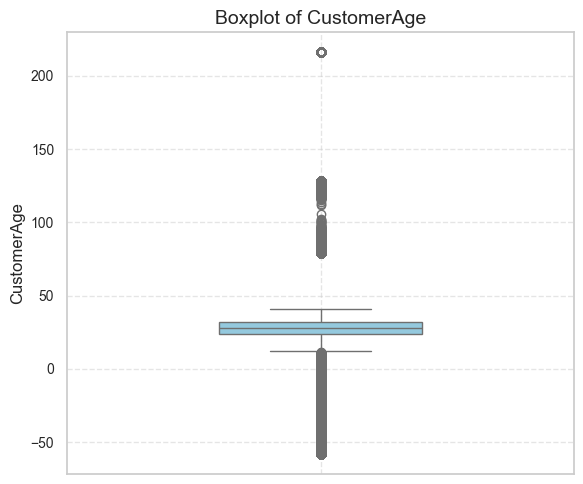

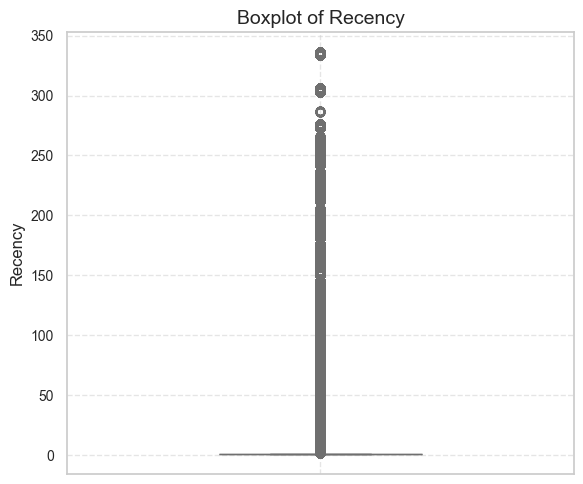

In [32]:
# Columns to plot
cols = ['Frequency', 'CustAccountBalance', 'TransactionAmount (INR)', 'CustomerAge', 'Recency']

# Set a clean style
sns.set(style="whitegrid")

# Loop through and create boxplots
for col in cols:
    plt.figure(figsize=(6, 5))
    sns.boxplot(y=MRF_df[col], color='skyblue', width=0.4)
    plt.title(f'Boxplot of {col}', fontsize=14)
    plt.ylabel(col, fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [33]:
# to claculate the otliers for each feature
lower_list=[]
upper_list=[]
num_list=[]
perc_list=[]
cols=['Frequency', 'CustAccountBalance','TransactionAmount (INR)', 'CustomerAge', 'Recency']
for i in cols:
    Q1 = MRF_df[i].quantile(0.25)
    Q3 = MRF_df[i].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    # calculate number of outliers
    num=MRF_df[(MRF_df[i] < lower) | (MRF_df[i] > upper)].shape[0]
    # calculate percentage of outliers
    perc = (num / MRF_df.shape[0]) * 100
    lower_list.append(lower)
    upper_list.append(upper)
    num_list.append(num)
    perc_list.append(round(perc,2))

    
dic={'lower': lower_list, 'upper': upper_list, 'outliers': num_list, 'Perc%':perc_list }
outliers_df=pd.DataFrame(dic,index=['Frequency', 'CustAccountBalance','TransactionAmount (INR)', 'CustomerAge', 'Recency'])
outliers_df


,lower,upper,outliers,Perc%
Frequency,1.000,1.000,141961,16.14
CustAccountBalance,-78334.780,145468.020,116569,13.26
TransactionAmount (INR),-1384.325,2816.195,91776,10.44
CustomerAge,12.000,44.000,150100,17.07
Recency,1.000,1.000,136120,15.48


In [34]:
MRF_df.head()

,Frequency,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDate,Recency
0,2,F,NOIDA,76340.635,2553.0,28.5,2016-09-17,18
1,1,M,MUMBAI,24204.490,1499.0,22.0,2016-08-14,1
2,2,F,MUMBAI,100112.950,727.5,28.0,2016-04-08,182
3,1,F,CHAMPARAN,496.180,30.0,26.0,2016-09-15,1
4,1,M,KOLKATA,87058.650,5000.0,-49.0,2016-08-18,1


### EDA

In [35]:
MRF_df.describe()

,Frequency,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDate,Recency
count,879357.000000,8.793570e+05,8.793570e+05,879357.000000,879357,879357.000000
mean,1.184517,1.147151e+05,1.566759e+03,30.881726,2016-07-26 00:35:32.299851008,15.876154
min,1.000000,0.000000e+00,0.000000e+00,-58.000000,2016-01-08 00:00:00,1.000000
25%,1.000000,5.591270e+03,1.908700e+02,24.000000,2016-06-09 00:00:00,1.000000
50%,1.000000,1.866578e+04,5.000000e+02,28.000000,2016-08-19 00:00:00,1.000000
75%,1.000000,6.154197e+04,1.241000e+03,32.000000,2016-09-09 00:00:00,1.000000
max,6.000000,1.150355e+08,1.560035e+06,216.000000,2016-12-09 00:00:00,336.000000
std,0.448954,8.010842e+05,6.433167e+03,48.136663,NaN,46.653921


In [36]:
print(MRF_df.dtypes)

Frequency                           int64
CustGender                         object
CustLocation                       object
CustAccountBalance                float64
TransactionAmount (INR)           float64
CustomerAge                       float64
TransactionDate            datetime64[ns]
Recency                             int64
dtype: object


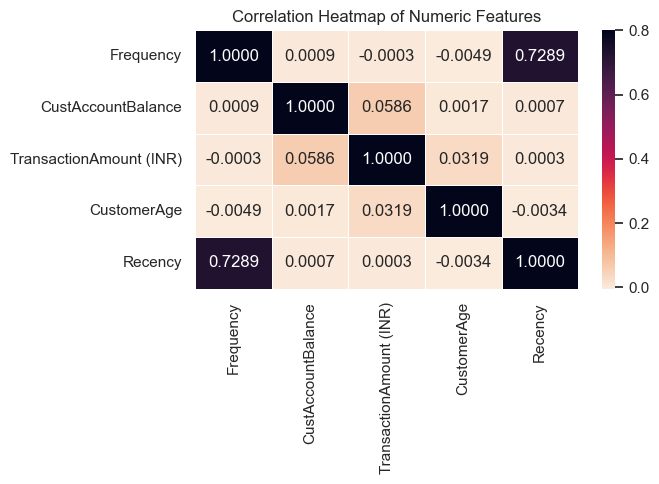

In [37]:
# Select only numeric columns for correlation
numerical_df = MRF_df.select_dtypes(include=['number'])

# Compute correlation matrix
correlation = numerical_df.corr()

# Plot the heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(
    correlation,
    vmin=None,
    vmax=0.8,
    cmap='rocket_r',
    annot=True,
    fmt='.4f',
    linecolor='white',
    linewidths=0.5,
    cbar=True
)
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()

C:\Users\91827\AppData\Local\Temp\ipykernel_23252\2897189156.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart=sns.countplot(x='Frequency',data=MRF_df,palette='rocket', order = MRF_df['Frequency'].value_counts().index)


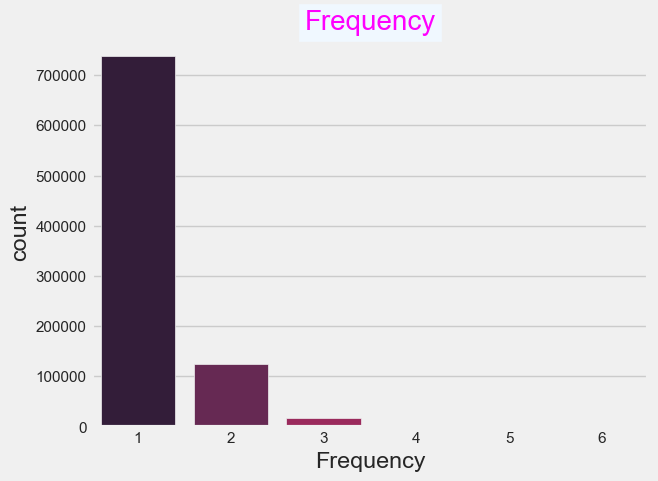

In [38]:
plt.style.use("fivethirtyeight")
chart=sns.countplot(x='Frequency',data=MRF_df,palette='rocket', order = MRF_df['Frequency'].value_counts().index)
plt.title("Frequency",
          fontsize='20',
          backgroundcolor='AliceBlue',
          color='magenta');

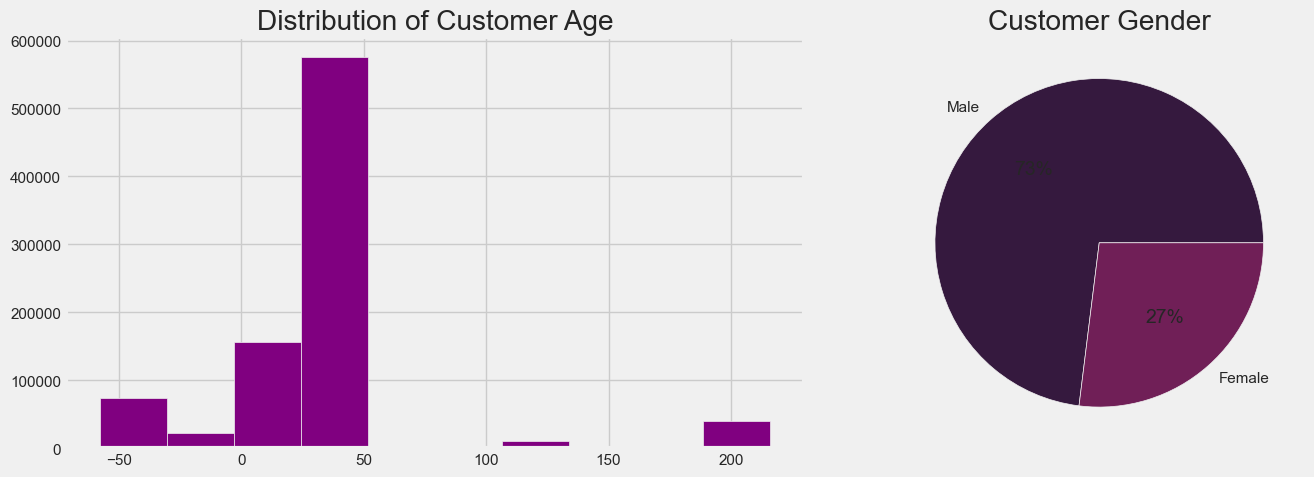

In [39]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(15,5))
palette_color = sns.color_palette('rocket')
ax[0].hist(x=MRF_df['CustomerAge'],color='purple')
ax[0].set_title("Distribution of Customer Age")
ax[1].pie(MRF_df['CustGender'].value_counts(),autopct='%1.f%%',colors=palette_color,labels=['Male','Female'])
ax[1].set_title("Customer Gender")
plt.tight_layout();

C:\Users\91827\AppData\Local\Temp\ipykernel_23252\1103490182.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  chart=sns.countplot(y='CustLocation',data=MRF_df,palette='rocket', order = MRF_df['CustLocation'].value_counts()[:20].index)


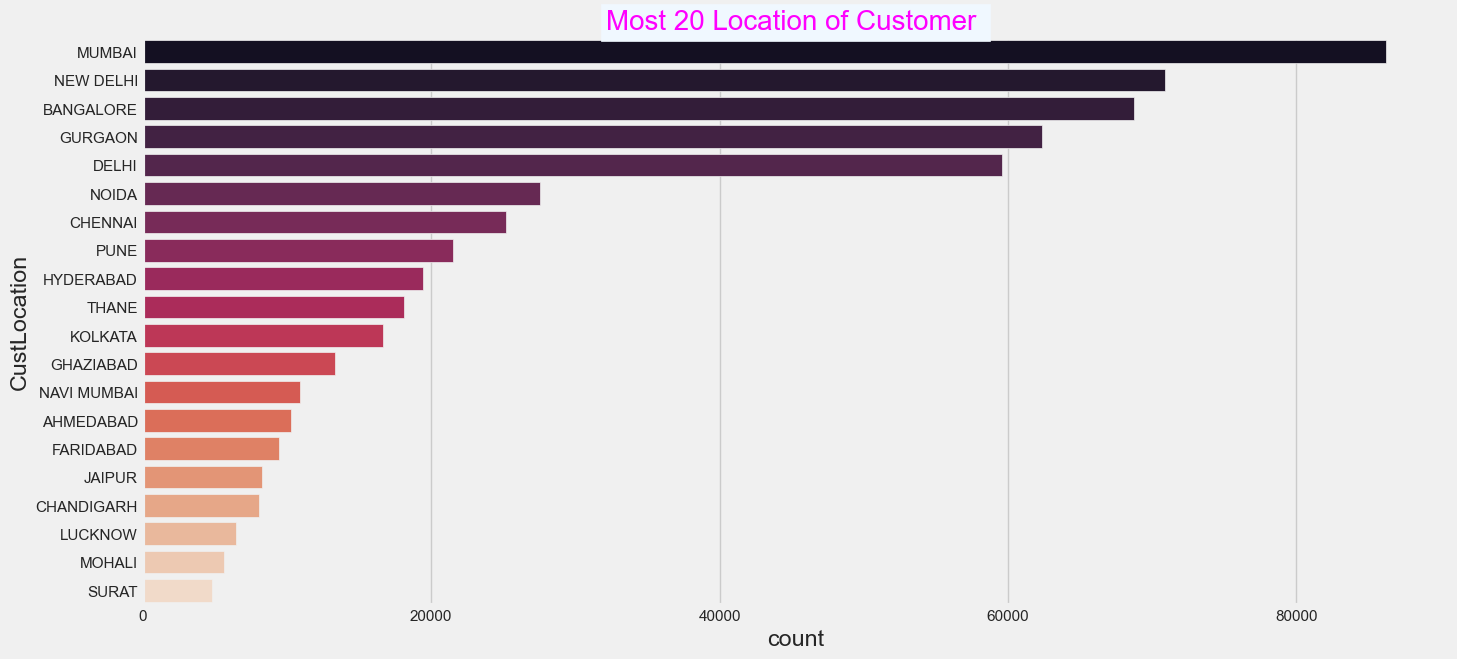

In [40]:
# How many customers are from each of the top 20 locations
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15,7))
chart=sns.countplot(y='CustLocation',data=MRF_df,palette='rocket', order = MRF_df['CustLocation'].value_counts()[:20].index)
plt.title("Most 20 Location of Customer ",
          fontsize='20',
          backgroundcolor='AliceBlue',
          color='magenta');


How much customers are spending per transaction

How much money they maintain in their accounts

How active they are (Frequency)

How recently they used the bank (Recency)

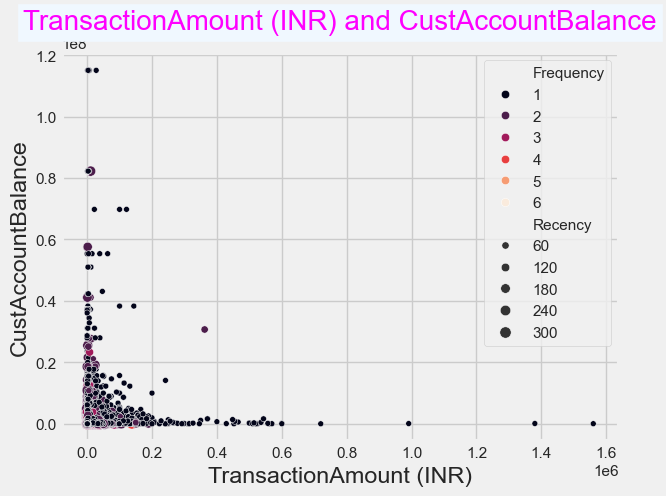

In [41]:
plt.style.use("fivethirtyeight")
sns.scatterplot(x='TransactionAmount (INR)',y='CustAccountBalance',data=MRF_df,palette='rocket',hue='Frequency',size='Recency' )
plt.title("TransactionAmount (INR) and CustAccountBalance",
          fontsize='20',
          backgroundcolor='AliceBlue',
          color='magenta');

In [42]:
# difference between maximum and minimum date
MRF_df['TransactionDate'].max()-MRF_df['TransactionDate'].min()

Timedelta('336 days 00:00:00')

In [45]:
## For each month, what was the average value of all numeric columns 
# (like Frequency, Account Balance, Transaction Amount, etc.) across all customers.
groupbby_month = MRF_df.groupby([pd.Grouper(key='TransactionDate', freq='M')])[[
    'Frequency', 'CustAccountBalance', 'TransactionAmount (INR)', 'CustomerAge', 'Recency'
]].mean()
print(groupbby_month.shape)
groupbby_month

(12, 5)


C:\Users\91827\AppData\Local\Temp\ipykernel_23252\770916628.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  groupbby_month = MRF_df.groupby([pd.Grouper(key='TransactionDate', freq='M')])[[


,Frequency,CustAccountBalance,TransactionAmount (INR),CustomerAge,Recency
TransactionDate,,,,,
2016-01-31,1.025196,107508.805797,1448.714678,31.290244,1.918747
2016-02-29,1.064317,105680.497569,1502.272034,31.577769,5.091711
2016-03-31,1.091612,111479.999592,1643.042085,30.546346,8.617264
2016-04-30,1.172430,114318.492265,1691.246723,29.639988,25.188155
2016-05-31,1.355424,109561.572298,1592.128640,30.679523,62.542281
2016-06-30,1.359702,109571.765181,1658.123285,30.355555,53.389229
2016-07-31,1.354797,106349.124901,1573.295768,29.868662,37.011021
2016-08-31,1.158752,120503.189601,1569.334883,31.105455,7.485432
2016-09-30,1.211712,117934.764734,1530.263571,31.473883,10.531790


#### CustAccountBalance	Are customers saving more or withdrawing funds over time?
#### TransactionAmount (INR)	Are they spending more or less in each transaction month-by-month?

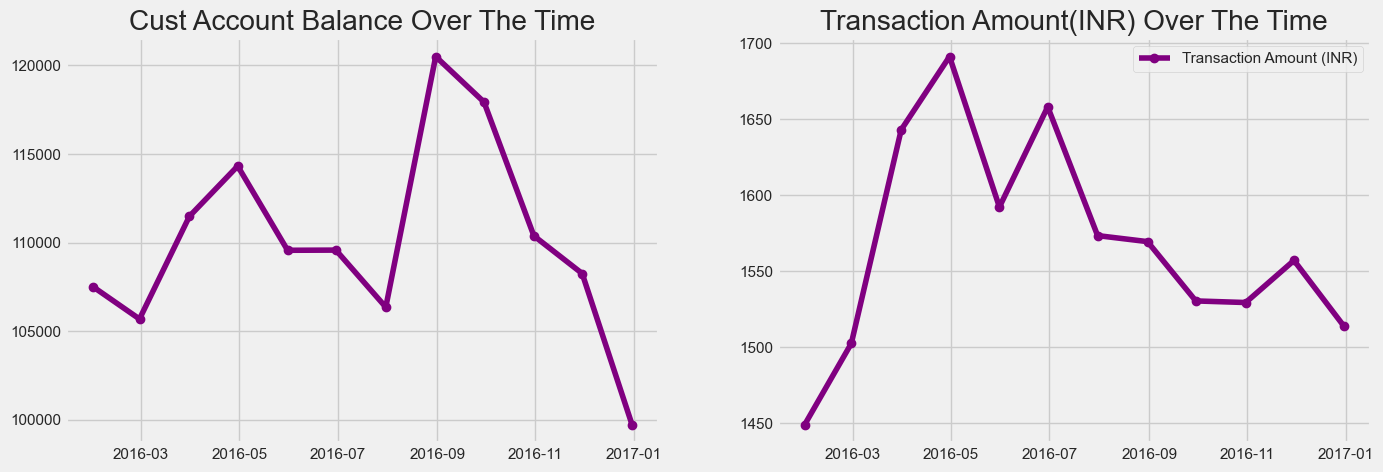

In [46]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(15,5))
ax[0].plot(groupbby_month.index,groupbby_month['CustAccountBalance'],color='purple',marker='o',label='Customer Account Balance')
ax[0].set_title('Cust Account Balance Over The Time')
ax[1].plot(groupbby_month.index,groupbby_month['TransactionAmount (INR)'],color='purple',marker='o',label='Transaction Amount (INR)')
ax[1].set_title("Transaction Amount(INR) Over The Time")
plt.legend();

### Feature Engineering

In [48]:
MRF_df=MRF_df.reset_index(drop=True)

In [49]:
MRF_df.head()

,Frequency,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDate,Recency
0,1,F,AHMEDABAD,703891.99,2000.00,29.0,2016-01-08,1
1,1,M,MUMBAI,156310.08,1347.90,-51.0,2016-01-08,1
2,1,M,OPP SAI BABA TEMPLE HYDERABAD,95792.79,9900.00,216.0,2016-01-08,1
3,1,M,DELHI,1753.41,154.05,27.0,2016-01-08,1
4,1,M,DELHI,39579.53,194.00,30.0,2016-01-08,1
